# Regridding CAM-SE Data 
## This notebook illustrates issues encountered when regridding CAM-SE data using ESMpy

<div>
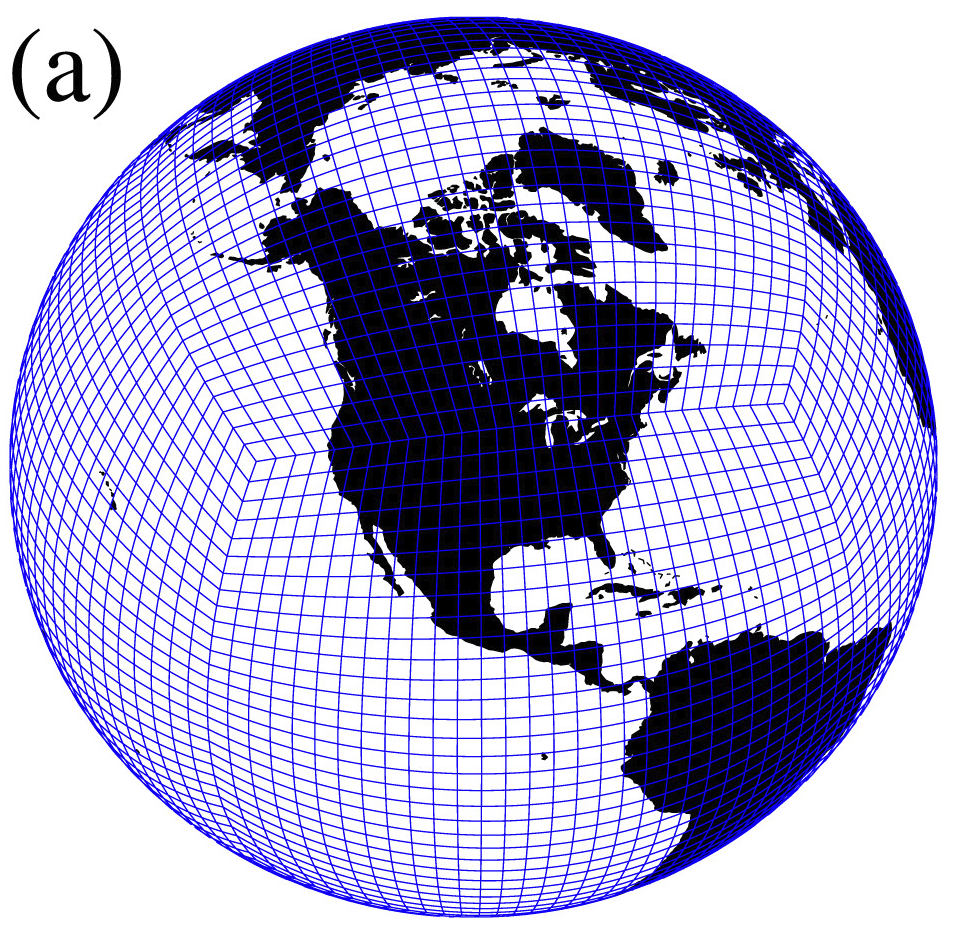
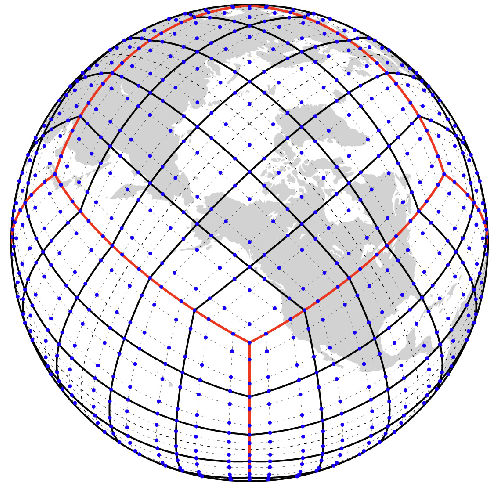
</div>

 _source:
 [LAURITZEN ET AL. (2018)](https://doi.org/10.1029/2017MS001257)_

In [1]:
import os
#!ml intel/2020b
#os.environ['LD_LIBRARY_PATH'] = '/sw/eb/sw/impi/2019.9.304-iccifort-2020.4.304/intel64/lib'
os.environ['I_MPI_PMI_LIBRARY']='/usr/lib64/libpmi.so'
import ESMF

import xarray as xr 
import numpy as np  
from cartopy.util import add_cyclic_point
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib as mpl
import matplotlib.ticker as mticker
import matplotlib.pyplot as plt
%matplotlib inline

#### Get single time-slice CAM data on different grids

In [2]:
scrdir = '/scratch/training/python_geos/data/esmpy'
srcgridnc = scrdir+'/ne120np4_pentagons_100310.nc'
dstgridnc = scrdir+'/latlon_0.25x0.25_0E_SCRIP_20191022.nc'
wgtfile = scrdir+'/ne120np4_pentagons_to_latlon_0.25x0.25_0E_conserve_20200309.nc'


ds_cam_ne120 = xr.open_dataset(scrdir+'/TREFHT_CAMne120.nc').isel(time=0)
ds_cam_ne120['lon'] = xr.where(ds_cam_ne120.lon>180,ds_cam_ne120.lon-360,ds_cam_ne120.lon)

In [3]:
# Plot Settings
def ax_features(ax):
    xticks = np.arange(-180, 210, 30)
    yticks = np.arange(-90,120,30)
    ax.add_feature(cfeature.COASTLINE, edgecolor='black',linewidth=1, zorder=1)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), linewidth=1, color='black', alpha=0.5)
    gl.ylocator = mticker.FixedLocator(yticks)
    gl.xlocator = mticker.FixedLocator(xticks)
    #ax.set_xticks(xticks)
    #ax.set_yticks(yticks)
    ax.set_aspect('auto')
    return ax

clevs = np.arange(0,15,1)*10+200

mymap = mpl.cm.get_cmap("YlOrRd").copy()
mymap.set_over('pink')
mymap.set_under('white')

### Can successfully load lat/lon SCRIP grid, but not ne120 grid:

In [ ]:
dstgrid = ESMF.Grid(filename=dstgridnc,filetype=ESMF.FileFormat.SCRIP)

In [6]:
# Create a field on the centers of the grid, with extra dimensions
dstfield = ESMF.Field(dstgrid, staggerloc=ESMF.StaggerLoc.CENTER)

In [7]:
srcmesh = ESMF.Mesh(filename=srcgridnc,filetype=ESMF.FileFormat.SCRIP,add_user_area=True)#parametric_dim=2,spatial_dim=3,add_user_area=True)

In [40]:
import numpy as np
srcfield=ESMF.Field(srcmesh, meshloc=ESMF.MeshLoc.ELEMENT)

#srcfield.data[:] = 1e20
# Read the field data from file
srcfield.read(scrdir+'/TREFHT_CAMne120.nc',variable="TREFHT", timeslice=0)
np.shape(srcfield.data) 

(777602,)

In [ ]:
#import MPI
wtfile_new='esmpy_example_weight_file.nc'
regrid = ESMF.Regrid(srcfield, dstfield,wtfile_new, regrid_method=ESMF.RegridMethod.BILINEAR,  
                     unmapped_action=ESMF.UnmappedAction.IGNORE)

In [42]:
# # create a regrid object from file
regrid = ESMF.RegridFromFile(srcfield, dstfield, wgtfile)

In [43]:
# calculate the regridding from source to destination field
dstfield = regrid(srcfield, dstfield)

if ESMF.local_pet() == 0:
    print ("Fields created from file regridded successfully :)")

Fields created from file regridded successfully :)


In [36]:
import xarray as xr
TREFHT_p25 = xr.DataArray(dstfield.data.T,coords={'lat': (['lat'], dstfield.grid.coords[0][1][0,:]),'lon': (['lon'], dstfield.grid.coords[0][0][:,0])})

In [18]:
# Plot Settings
def ax_features(ax):
    xticks = np.arange(-180, 210, 30)
    yticks = np.arange(-90,120,30)
    ax.add_feature(cfeature.COASTLINE, edgecolor='black',linewidth=1, zorder=1)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), linewidth=1, color='black', alpha=0.5)
    gl.ylocator = mticker.FixedLocator(yticks)
    gl.xlocator = mticker.FixedLocator(xticks)
    #ax.set_xticks(xticks)
    #ax.set_yticks(yticks)
    ax.set_aspect('auto')
    return ax

clevs = np.arange(0,15,1)*10+200

mymap = mpl.cm.get_cmap("YlOrRd").copy()
mymap.set_over('pink')
mymap.set_under('white')

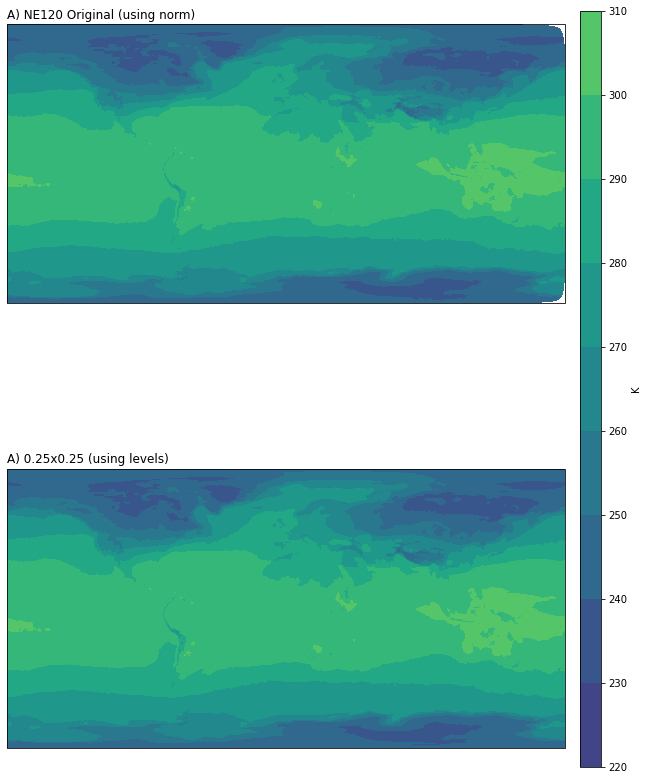

In [50]:
# Plot
fig = plt.figure(figsize=(10,15))
var = 'TREFHT'
nrows=2
ncols=1

ax1 = fig.add_subplot(nrows,ncols,1, projection=ccrs.PlateCarree())
#ax1 = ax_features(ax1)
ax1.set_title('A) NE120 Original (using norm)',fontsize=12, loc='left')
cntr1 = ax1.tricontourf(dsn.lon, dsn.lat, dsn.TREFHT.isel(time=0),
                        norm=mpl.colors.BoundaryNorm(clevs, ncolors=256, extend='both'),
                       #levels=clevs, 
                       transform=ccrs.PlateCarree())
ax1.set_global()

ax2 = fig.add_subplot(nrows,ncols,2, projection=ccrs.PlateCarree())
#ax2 = ax_features(ax2)
ax2.set_title('A) 0.25x0.25 (using levels)',fontsize=12, loc='left')
cntr2 = ax2.contourf(TREFHT_p25.lon, TREFHT_p25.lat, TREFHT_p25,
                        norm=mpl.colors.BoundaryNorm(clevs, ncolors=256, extend='both'),
#                       levels=clevs, 
                       transform=ccrs.PlateCarree())
ax2.set_global()


cbar_ax = fig.add_axes([0.92, 0.15, 0.03, 0.7])
fig.colorbar(cntr2, cax=cbar_ax, label='K', orientation='vertical')

In [46]:
dsn['lon'] = xr.where(dsn.lon>180,dsn.lon-360,dsn.lon)